## Задание
<i>Обозначения:</i>

* p - глубина истории, сколько измерений назад учитываем в моделях
* h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

Оцените ошибку модели из п.1 .

Сделайте вывод о том, как изменилась ошибка модели по значениям h.

In [1]:
import numpy as np
import pandas as pd 

import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

**Загружаем данные**

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145374 entries, 2002-01-01 to 2018-08-03
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             145374 non-null  object 
 1   PJME_MW          145374 non-null  float64
 2   year             145374 non-null  int64  
 3   month            145374 non-null  int64  
 4   dayofmonth       145374 non-null  int64  
 5   quarter          145374 non-null  int64  
 6   dayofyear        145374 non-null  int64  
 7   weekofyear       145374 non-null  int64  
 8   dayofweek        145374 non-null  int64  
 9   hour             145374 non-null  int64  
 10  is_holiday       145374 non-null  int64  
 11  is_prev_holiday  145374 non-null  int64  
 12  is_next_holiday  145374 non-null  int64  
dtypes: float64(1), int64(11), object(1)
memory usage: 15.5+ MB


In [3]:
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [4]:
data.index

DatetimeIndex(['2002-01-01', '2002-01-01', '2002-01-01', '2002-01-01',
               '2002-01-01', '2002-01-01', '2002-01-01', '2002-01-01',
               '2002-01-01', '2002-01-01',
               ...
               '2018-08-02', '2018-08-02', '2018-08-02', '2018-08-02',
               '2018-08-02', '2018-08-02', '2018-08-02', '2018-08-02',
               '2018-08-02', '2018-08-03'],
              dtype='datetime64[ns]', name='Date', length=145374, freq=None)

**Функция экспоненциального сглаживания**

In [5]:
def exponential_smoothing(series, alpha):
    n = series.shape[0]//10
    result = [np.mean(series[0:n])] # начинать лучше со среднего значения
    
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

**Ресемплирование и экспоненциальное сглаживание**

In [6]:
resampled_data = data.resample('D').mean()
data_exp_smoothed = exponential_smoothing(resampled_data['PJME_MW'], 0.1)

**Посмотрим что получилось**

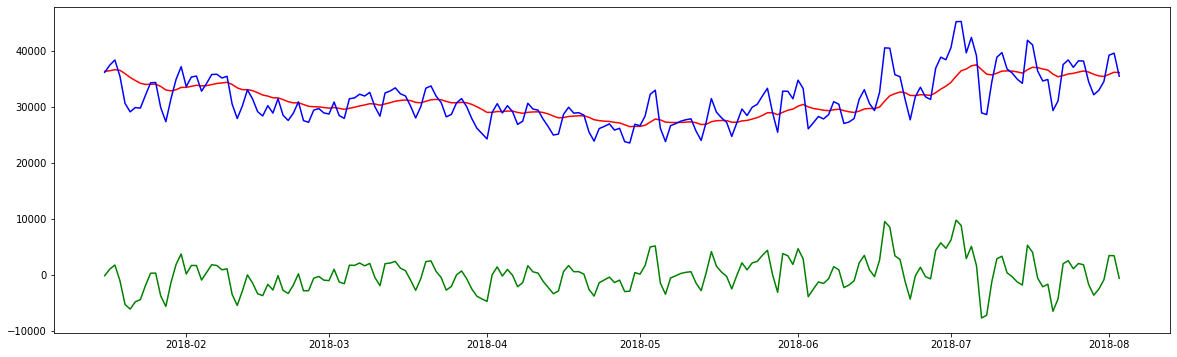

In [8]:
plt.figure(figsize=(20, 6))
plt.plot(resampled_data[-200:].index, data_exp_smoothed[-200:], 'r')
plt.plot(resampled_data[-200:].index, resampled_data[-200:]['PJME_MW'], 'b')
plt.plot(resampled_data[-200:].index, resampled_data[-200:]['PJME_MW'] - data_exp_smoothed[-200:], 'g')

In [9]:
df_exp_smoothed = pd.DataFrame(data = data_exp_smoothed, index = resampled_data.index)
data_trend_free = (resampled_data['PJME_MW'] - df_exp_smoothed.iloc[:,0])

**Проверка ряда на стационарность**

In [10]:
ADF_data_trend_free = sm.tsa.stattools.adfuller(data_trend_free, regression='ctt')
print(f'p-value = {ADF_data_trend_free[1]}')

p-value = 1.7343466829488e-13


Т.к. **p-value** практически стремится к 0, следовательно первоначальный ряд за вычетом данных из ряда с экспоненциальным сглаживанием является стационарным.

In [11]:
df = df_exp_smoothed

Учитывать только глубину истории при p=3

In [12]:
df['t2'] = 0
df.iloc[3:, 1] = df.iloc[:-3, 0].values
df.fillna(0).head()

,0,t2
Date,,
2002-01-01,31925.426497,0.000000
2002-01-02,32159.038014,0.000000
2002-01-03,32394.321713,0.000000
2002-01-04,32526.435375,31925.426497
2002-01-05,32314.304337,32159.038014


экспоненциальное сглаживание

In [13]:
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_05'] = exponential_smoothing(df[0], 0.05)
df['exp_0_1'] = exponential_smoothing(df[0], 0.1)

1-й порядок разностей

In [14]:
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[1:, 0].values - df.iloc[:-1, 0].values

df.head(4)

,0,t2,exp_0_01,exp_0_05,exp_0_1,diff1
Date,,,,,,
2002-01-01,31925.426497,0.000000,31847.310564,31847.310564,31847.310564,0.000000
2002-01-02,32159.038014,0.000000,31850.427838,31862.896936,31878.483309,233.611517
2002-01-03,32394.321713,0.000000,31855.866777,31889.468175,31930.067149,235.283699
2002-01-04,32526.435375,31925.426497,31862.572463,31921.316535,31989.703972,132.113662


**Разбивка датасета на тестовую и тренировочную**

In [15]:
def split_dataframe(data, split_date):
    """
    Split dataframe by date as delimiter
    """
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train, test = split_dataframe(df, '2018-05-01')


**средняя абсолютная ошибка в процентах (mean percentage absolute error, MAPE)**

In [16]:
def map_error(y_true, y_pred, h):
    """
    Mean absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return print(f'Средняя ошибка = {np.mean(np.abs((y_true - y_pred) / y_true)) * 100 :.2f}%'
                 f' при горизонте прогноза h = {h}')

In [17]:
h = 1

X_train = train.iloc[:-h, :]
y_train = train[0].values[h:]
X_test = test.iloc[:-h, :]
y_test = test[0].values[h:]

**Предсказание**

In [18]:
model = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model.fit(X_train, y_train) 

y_test_pred = model.predict(X_test)

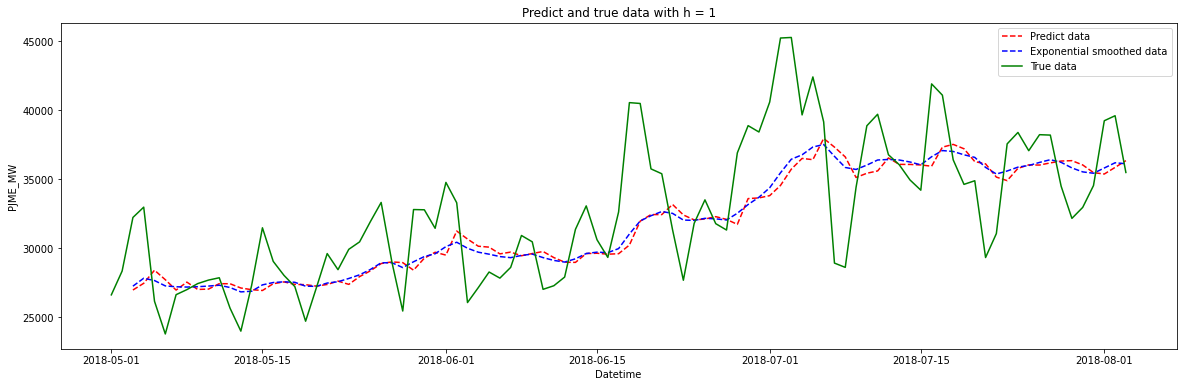

In [19]:
plt.figure( figsize=(20, 6))

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.plot(test.index[h:], y_test_pred, '--r', label='Predict data')
plt.plot(test.index[h:], y_test, '--b', label='Exponential smoothed data')
plt.plot(resampled_data.loc['2018-05-01':].index, resampled_data.loc['2018-05-01':]['PJME_MW'], 'g', label='True data')
plt.title(f'Predict and true data with h = {h}')

plt.legend()
plt.show()

In [20]:
y_test[-4:], y_test_pred[-4:]

(array([35429.67398687, 35809.78575485, 36188.11134603, 36117.90021143]),
 array([35475.46865606, 35373.62099197, 35853.03934239, 36342.55436897]))

In [21]:
map_error(y_test, y_test_pred, h)

Средняя ошибка = 0.98% при горизонте прогноза h = 1


**Изменим Гаризоннт прогноза = 10**

In [22]:
h = 10

X_train = train.iloc[:-h, :]
y_train = train[0].values[h:]
X_test = test.iloc[:-h, :]
y_test = test[0].values[h:]

# Предсказание
model = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model.fit(X_train, y_train) 

y_test_pred = model.predict(X_test)

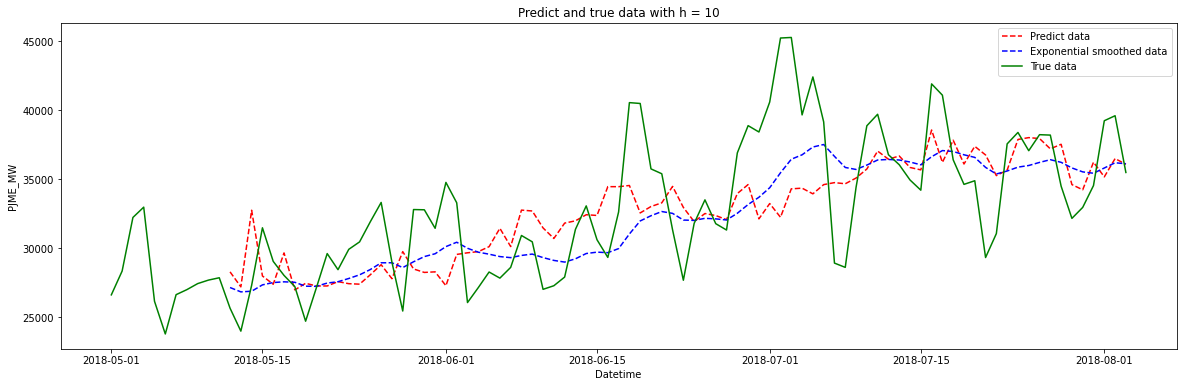

In [23]:

plt.figure( figsize=(20, 6))

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.plot(test.index[h:], y_test_pred, '--r', label='Predict data')
plt.plot(test.index[h:], y_test, '--b', label='Exponential smoothed data')
plt.plot(resampled_data.loc['2018-05-01':].index, resampled_data.loc['2018-05-01':]['PJME_MW'], 'g', label='True data')
plt.title(f'Predict and true data with h = {h}')

plt.legend()
plt.show()

In [24]:
map_error(y_test, y_test_pred, h)

Средняя ошибка = 4.08% при горизонте прогноза h = 10


**Выводы**

При росте горизонта прогноза ошибка ожидаемо выросла от 0.98% при h = 1 до 4.08% при h = 10.

**Задание 2**

Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

+ Изменение температуры за окном.
+ Количество денег, которые тратят покупатели в интернет магазине.
+ Вес растущего котенка.
+ Прирост объема деревьев в лесу от времени

* Изменение температуры за окном - с сезоном (лето/зима), с циклом (например, в зависимости от ветров), с трендом (потепление или похолодание климата).
* Количество денег, которые тратят покупатели в интернет магазине - с сезоном (зима/лето, по дням недели), с циклом (в привязке к праздникам), с трендом из-за инфляции.
* Вес растущего котенка - с трендом (рост замедляется с возрастом).
* Прирост объема деревьев в лесу от времени - с сезоном (летом прирост больше).